## TASK 3

### Import the required packages  
In this cell the required packages for the task are imported.

In [109]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from skimage import morphology

### Import the images  
In this cell both images on which code will be tested are imported.

In [110]:
#import the first image
image1 = cv2.imread('task_3_image_1.png', cv2.IMREAD_GRAYSCALE) 
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
# import the second image
image2 = cv2.imread('task_3_image_2.png', cv2.IMREAD_GRAYSCALE) 
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

### Function from Task 2 for resizing the images  
This cell code is a function from Task 2 for resizing the images

In [111]:
def resize(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image to create a binary mask
    _, binary = cv2.threshold(gray, 65, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (assuming it is the petri dish)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Determine the size of the square
    side_length = max(w, h)

    # Calculate the center of the bounding box
    center_x = x + w // 2
    center_y = y + h // 2

    # Calculate the coordinates for the square crop
    new_x = max(0, center_x - side_length // 2)
    new_y = max(0, center_y - side_length // 2)
    new_x_end = min(image.shape[1], center_x + side_length // 2)
    new_y_end = min(image.shape[0], center_y + side_length // 2)

    # Crop the image to the square
    cropped_image = image[new_y:new_y_end, new_x:new_x_end]

    # Display the cropped image (optional)
    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Image")
    plt.axis("off")
    plt.show()

    return cropped_image, (new_x, new_y, side_length, side_length)

### Function to Extract the Upper Half of an Image

This cell defines a function called `half_image`, which takes an image as input and returns the upper half of the image. The function works by computing the midpoint of the height and slicing the image accordingly.


In [112]:
def half_image(image):
    # Get the dimensions of the image
    height, width, channels = image.shape
    
    # Compute the height of the upper half
    upper_half_height = height // 2
    
    # Slice the upper half of the image
    upper_half = image[:upper_half_height, :, :]
    
    return upper_half

### Image Segmentation Function

This cell defines a function `segmentation` that performs segmentation on an input image. The function uses various preprocessing steps such as grayscaling, Gaussian blurring, thresholding, morphological operations, and connected components analysis. It visualizes the contours and segmented labels of the image and returns the labeled components.

#### Steps Included:
1. Convert the image to grayscale.
2. Apply Gaussian blur to smooth the image.
3. Perform binary thresholding to separate the foreground from the background.
4. Use morphological operations (opening and closing) to clean up noise.
5. Remove small objects using `skimage`'s `remove_small_objects`.
6. Detect contours using Canny edge detection.
7. Visualize the contours drawn on the original image.
8. Analyze connected components to assign unique labels to regions and visualize the labels.


In [113]:
def segmentation(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to smooth the image
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    # Perform binary thresholding to create a binary image
    _, thresh = cv2.threshold(gray, 165, 255, cv2.THRESH_BINARY_INV)
    # Apply morphological operations to clean up noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    binary_cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    binary_cleaned = cv2.morphologyEx(binary_cleaned, cv2.MORPH_CLOSE, kernel)
    binary_cleaned = morphology.remove_small_objects(binary_cleaned.astype(bool), min_size=1000, connectivity=1)
    binary_cleaned = binary_cleaned.astype(np.uint8) * 255
    # Perform connected components analysis
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_cleaned)
    # Detect edges using Canny edge detection
    edges = cv2.Canny(binary_cleaned, threshold1=165, threshold2=170)
    # Find and draw contours on the original image
    contours, hierarchy = cv2.findContours(edges, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    # Create a copy of the original image
    image_with_contours = image.copy()
    # Draw contours in green
    cc = cv2.drawContours(image, contours, -1, (0, 255, 0), 2)

    # Visualize the image with contours
    plt.imshow(cv2.cvtColor(cc, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title("Contours Drawn")
    plt.axis('off')
    plt.show()
    
    # Visualize labels
    plt.imshow(labels, cmap='jet')
    plt.title("All labels before filtering")
    plt.show()
    
    return labels

### Function to Filter and Visualize Labels by Area

This function filters the labels based on their areas, selecting the 2nd to 6th largest (which are the Petri Dishes labels) labeled regions, and then visualizes them with distinct colors using a colormap. The labels are normalized for proper application of the colormap, and the resulting image is returned as a colored array.

#### Steps Included:
1. Calculate the area (pixel count) for each label, excluding the background (label `0`).
2. Sort the labels by area in descending order.
3. Select the 2nd to 6th largest labels for processing.
4. Normalize the labels to the range `[0, 1]`.
5. Apply the `viridis` colormap to assign distinct colors to each label.
6. Convert the resulting array into an 8-bit RGB format.
7. Return the processed colored labels.


In [114]:
def labels(labels):
    # Calculate areas for each label (excluding background, label 0)
    unique_labels = np.unique(labels)
    areas = [(label, np.sum(labels == label)) for label in unique_labels if label != 0]

    # Sort labels by area in descending order
    sorted_labels = sorted(areas, key=lambda x: x[1], reverse=True)

    # Extract the 2nd to 6th largest labels
    selected_labels = [label[0] for label in sorted_labels[1:6]]

    # Create a mask for the selected labels
    filtered_labels = np.isin(labels, selected_labels).astype(np.uint8) * labels

    # Normalize the labels for colormap application
    normalized_labels = filtered_labels / np.max(filtered_labels)

    # Apply a colormap to assign unique colors to each label
    cmap = plt.cm.viridis  # Use "viridis" colormap
    colored_labels = cmap(normalized_labels)[:, :, :3]  # Extract only RGB channels

    # Convert the array to uint8 for proper visualization
    colored_labels = (colored_labels * 255).astype(np.uint8)

    return colored_labels

### Function to Create a Full-Size Image with Segmentation Overlaid

This function takes a cropped segmentation image and places it onto a blank image with the same size as the original image. The blank image is initialized with the background color from the segmentation image. The segmentation is positioned on top of the original-sized blank image.

#### Steps Included:
1. Extract the background color from the segmentation image (top-left pixel).
2. Create a blank image with the same dimensions as the original image.
3. Overlay the segmentation image onto the blank image at the top position.
4. Return the resulting full-size image with the segmentation overlaid.


In [115]:
def create_full_image_with_segmentation(segmentation_image, original_size):
    # Get the background color from the segmentation image (top-left pixel)
    background_color = segmentation_image[0, 0]

    # Create a blank image with the same size as the original image
    full_image = np.full(original_size, background_color, dtype=np.uint8)

    # Place the segmentation image in the top half of the blank image
    full_image[:segmentation_image.shape[0], :segmentation_image.shape[1]] = segmentation_image

    return full_image

### Print the Cropped Image - Image 1 and Image 2

### Image 1

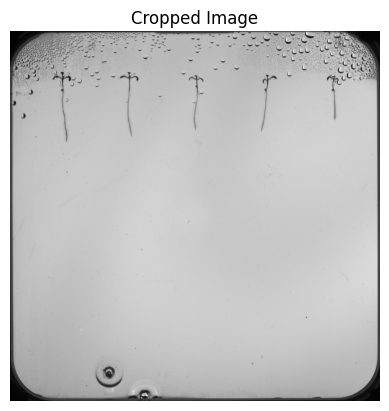

In [116]:
# function from task 2
cropped_image, crop_coordinates = resize(image1)
# function to get the upper half of the cropped image
im_halfed = half_image(cropped_image)

### Perform Image Segmenation

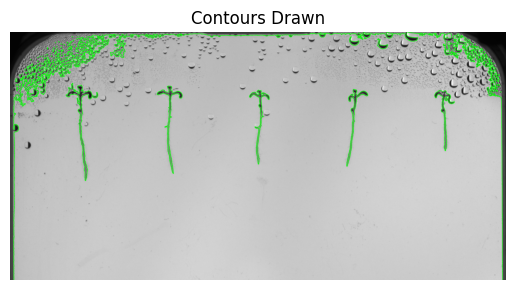

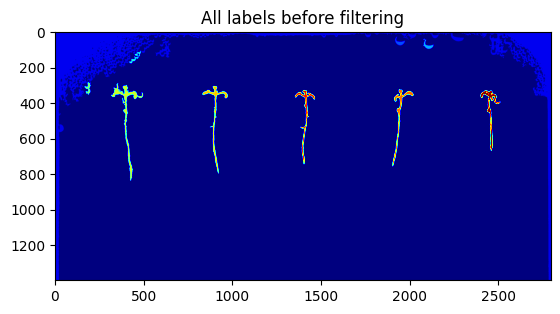

In [117]:
# function for the steps of image segmentation
im_segmented = segmentation(im_halfed)
# function to extract the petri dish labels
im_labeled = labels(im_segmented)

### Revert to the original image size and extract the petri dish labels

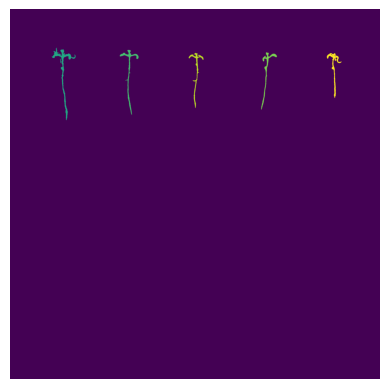

In [118]:
# Get the size of the original image
original_size = cropped_image.shape
# function to create the new image
final_im = create_full_image_with_segmentation(im_labeled, original_size)
plt.imshow(final_im)
plt.axis('off')
plt.show()

### Try the same code cells for the second image

### Image 2

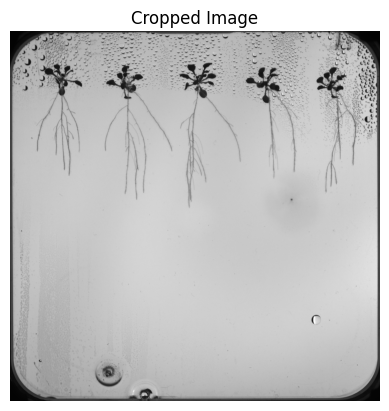

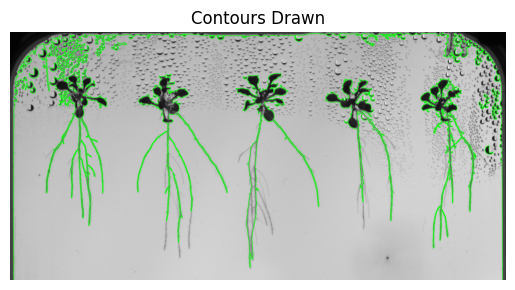

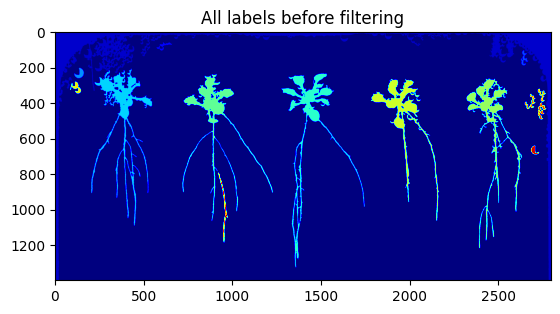

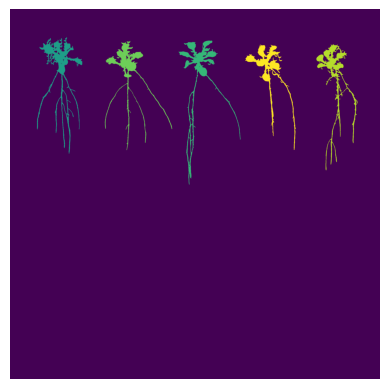

In [119]:
# function from task 2
cropped_image, crop_coordinates = resize(image2)
# function to get the upper half of the cropped image
im_halfed = half_image(cropped_image)
# function for the steps of image segmentation
im_segmented = segmentation(im_halfed)
# function to extract the petri dish labels
im_labeled = labels(im_segmented)
original_size = cropped_image.shape  # Get the size of the original image
final_im = create_full_image_with_segmentation(im_labeled, original_size)
plt.imshow(final_im)
plt.axis('off')
plt.show()